# Testing dimensionality reduction as a way to describe brain state

In [1]:
import os
import numpy as np
import mne
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator
from mne.preprocessing import ICA
from mne.time_frequency import psd_array_welch
import pyxdf
from fooof import FOOOF
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\Jake\AppData\Local\Temp\ipykernel_14312\3004124268.py:9: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


[[  1.33423485  -0.77578518  -4.32850324 ... -18.24585265 -21.2298683
  -14.84936941]
 [  0.99828802  -5.17583933 -10.23671394 ... -10.95429872 -14.1534491
  -10.90478706]
 [ -1.91052058  -4.60520828  -3.61084957 ... -14.2255921  -13.89697297
   -6.81327015]
 ...
 [ -1.53408299  -6.6318894   -6.93412676 ... -16.16532947 -16.64019224
  -11.68179864]
 [ -2.59360157  -6.61478819  -6.04939334 ... -14.56862235 -17.96090038
  -14.83981786]
 [ -3.95529507  -9.47602521  -9.29842538 ...  -8.7726851  -14.3947761
  -16.49501773]]
256.0
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Using qt as 2D backend.


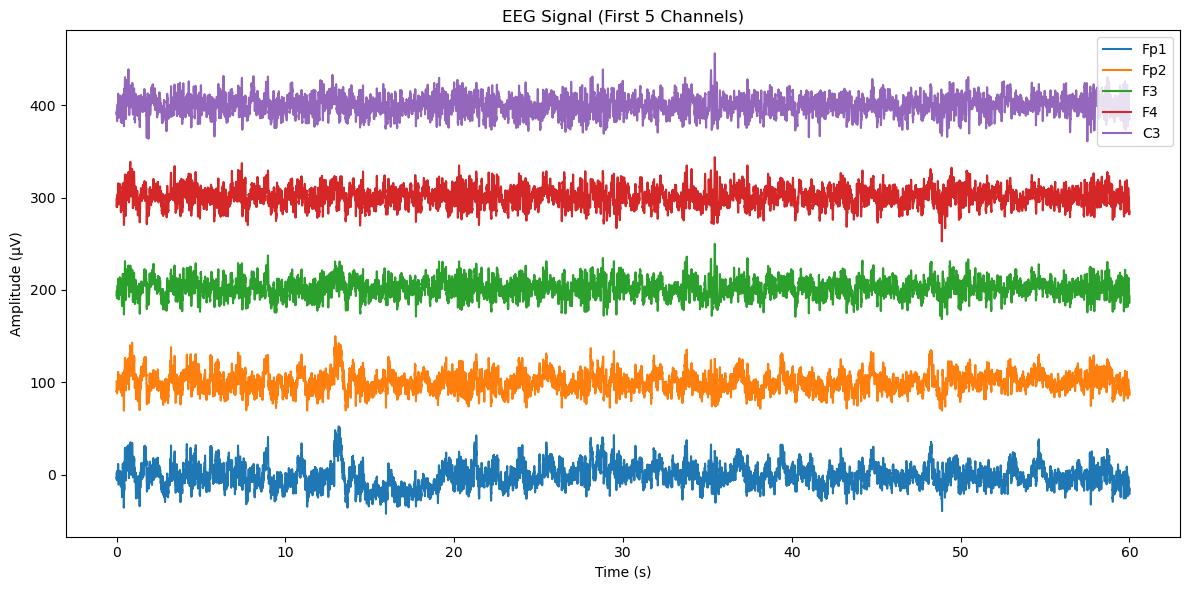

Channels marked as bad:
none


In [ ]:
project_directory = os.path.dirname(os.path.dirname(os.path.abspath("umap_test")))


streams, header = pyxdf.load_xdf(os.path.join(project_directory, r"Data", r"Sub1_RS_EC.xdf"))
eeg_stream = streams[0]
RS_EC = np.array(eeg_stream['time_series']).T  # Transpose to channels x samples
sfreq = float(eeg_stream['info']['nominal_srate'][0])  # Sampling frequency
ch_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']  # Channel names
ch_names = [ch['label'][0] for ch in ch_names]

print(RS_EC)
print(sfreq)
print(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

raw_RS_EC = mne.io.RawArray(RS_EC, info)
raw_RS_EC.rename_channels({ch: ch.capitalize() for ch in raw_RS_EC.ch_names})
    # Add standard montage (10-20 system)
montage = mne.channels.make_standard_montage('standard_1020')
raw_RS_EC.set_montage(montage)
raw_RS_EC.plot(title="Resting State EEG (Eyes Closed)", scalings='auto')


data = raw_RS_EC.get_data()

time = np.arange(data.shape[1]) / sfreq

plt.figure(figsize=(12, 6))
for i in range(min(5, data.shape[0])):  # Plot up to 5 channels
    plt.plot(time, data[i] + i * 100, label=ch_names[i])  # Offset each channel for clarity
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("EEG Signal (First 5 Channels)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
def load_xdf_to_raw(xdf_file):
    # Load the XDF file using pyxdf
    streams, header = pyxdf.load_xdf(xdf_file)
    
    # Assume the first stream is the EEG data
    eeg_stream = streams[0]
    
    # Get EEG data and metadata
    data = np.array(eeg_stream['time_series']).T  # Transpose to channels x samples
    sfreq = float(eeg_stream['info']['nominal_srate'][0])  # Sampling frequency
    ch_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']  # Channel names
    ch_names = [ch['label'][0] for ch in ch_names]  
    
    # Create MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Normalize channel names (capitalize correctly for montage matching)
    raw.rename_channels({ch: ch.capitalize() for ch in raw.ch_names})
    
    # Add standard montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    return raw

raw_rs = load_xdf_to_raw(os.path.join(project_directory, r"Data", r"Sub1_RS_EC.xdf"))
raw_breath = load_xdf_to_raw(os.path.join(project_directory, r"Data", r"Sub1_Breath_EC.xdf"))

print(raw_rs)
print(raw_breath)

Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
<RawArray | 19 x 15360 (60.0 s), ~2.3 MB, data loaded>
<RawArray | 19 x 15360 (60.0 s), ~2.3 MB, data loaded>


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


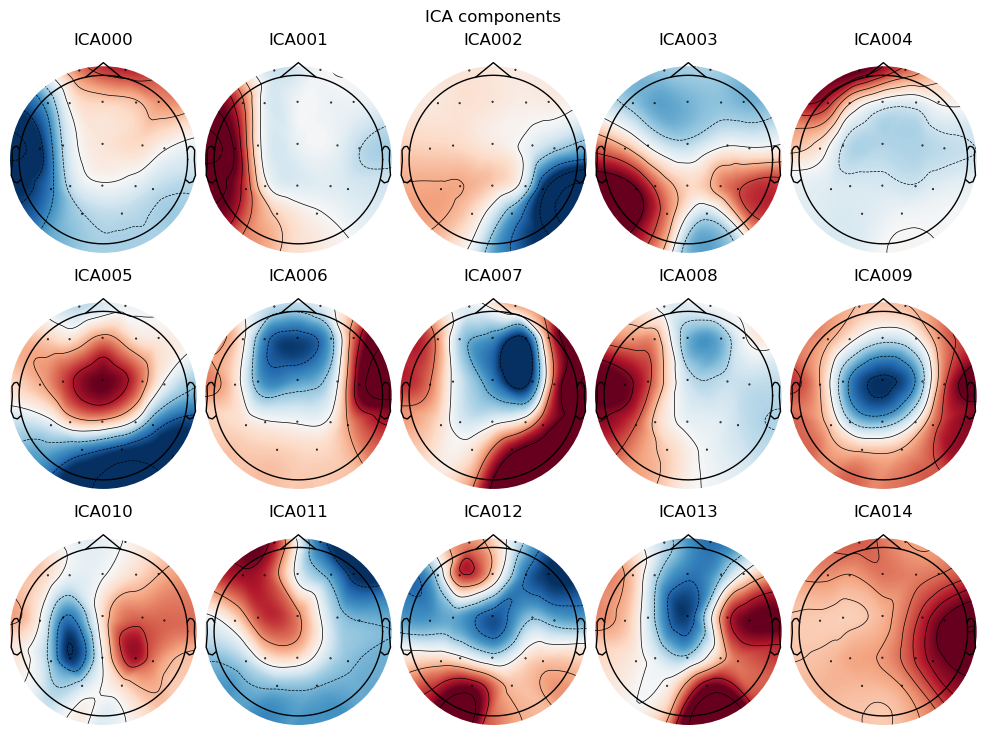

Effective window size : 16.000 (s)
Automatically identified muscle ICs: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Removed notch frequencies (Hz):
     60.00 :  209 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-06 01:02:58,152 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['Fp1'], 'bad_all': ['Fp1']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-06 01:02:58,562 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}
2024-12-06 01:02:58,568 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-06 01:02:59,017 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['Fp1'], 'bad_all': ['Fp1']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors


2024-12-06 01:02:59,050 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-06 01:02:59,476 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['Fp1'], 'bad_all': ['Fp1']}
2024-12-06 01:02:59,477 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

1 by RANSAC: ['Fp1']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 512 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitted sphere radius:         95.4 mm
Origin head coordinates:      -1.0 15.6 45.4 mm
Origin device coordinates:    -1.0 15.6 45.4 mm


Dropped 2 epochs: 0, 1
The following epochs were marked as bad and are dropped:
[0, 1]
Channels marked as bad:
none
Channels marked as bad:
['Pz']
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
import mne
from mne.preprocessing import ICA
from pyprep.prep_pipeline import PrepPipeline
from autoreject import AutoReject
from mne.preprocessing import compute_current_source_density

raw = raw_rs

#raw.filter(1.0, 50.0)
# Re-reference
#raw.set_eeg_reference('average', projection=False)
ica = ICA(n_components=15, random_state=42)
ica.fit(raw)
ica.plot_components() 
muscle_inds, scores = ica.find_bads_muscle(raw, threshold=2.0)  # Detect muscle artifacts
print(f"Automatically identified muscle ICs: {muscle_inds}")
ica.exclude.extend(muscle_inds) # Identify artifact components manually
ica.apply(raw)

# Visualize
raw.plot(title="Preprocessed Raw Data", scalings='auto')


montage = raw.get_montage()
raw.load_data()


prep_params = {
        "ref_chs": "eeg",  # Use all EEG channels for referencing
        "reref_chs": "eeg",  # Channels for final re-referencing
        "line_freqs": [60],  # Adjust for your location (50 Hz for Europe, 60 Hz for US)
    }
prep = PrepPipeline(raw, prep_params, montage)
prep.fit()
raw.info["bads"] = prep.interpolated_channels  # Mark channels for interpolation
raw.interpolate_bads()

def autoreject_epochs(raw):
    # Create fixed-length epochs for autoreject to process
    epochs = mne.make_fixed_length_epochs(raw, duration=4.0, overlap=0.0, preload=True)
    
    # Initialize and fit Autoreject
    ar = AutoReject(random_state=42, n_jobs=-1)
    epochs_clean = ar.fit_transform(epochs)
    
    return epochs_clean

epochs_clean = autoreject_epochs(raw)
epochs_clean.plot(title='epochs_clean', scalings = 'auto')

def apply_csd(epochs):
    # Compute the CSD transformation to minimize volume conduction
    epochs_csd = compute_current_source_density(epochs)
    return epochs_csd

epochs_csd = apply_csd(epochs_clean)
epochs_csd.plot(title='epochs_csd', scalings = 'auto')

